In [1]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join('..')))

import pandas as pd
import numpy as np
import math
import itertools
import re
import json

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from src import analysis
from src import framework
from src import ab_tests
from src.framework import print_title

In [3]:
import importlib
importlib.reload(analysis)
importlib.reload(framework)
importlib.reload(ab_tests)

<module 'src.ab_tests' from '/Users/jobandtalent/Documents/GitHub/ab-test-framework/src/ab_tests.py'>

# EXPERIMENT DESIGN

#### SOURCES INGESTION

In [6]:
# Load raw data
file_name = 'ab_test_example_2.csv'
df_raw = pd.read_csv('../data/' + file_name)
display(df_raw.head(5))

# Make a copy
df = df_raw.copy()

# Check dtypes
print_title('INITIAL DATA TYPES')
print(df.dtypes)

,index,platform,recipe_views
0,0,android,2
1,1,android,4
2,2,android,1
3,3,android,1
4,4,android,2


-------------------- INITIAL DATA TYPES --------------------
index            int64
platform        object
recipe_views     int64
dtype: object


#### METRIC SELECTION

In [7]:
# calculate the metrics, use metric_cnt_ or metric_cvr_
df['metric_cnt_recipe_views'] = df['recipe_views']

#### EXPERIMENT DESIGN

In [9]:
sample_data_df = df.copy()
np.random.seed(42)

# Experiment Parameters
effect_size = 0.1  # MDE relative percentage (0.02 = 2%)
daily_traffic = 10000  # Daily users
traffic_proportion = 0.5 # Proportion of daily users use for the experiment
metric_column = 'metric_cnt_recipe_views'
is_sample_data_available = True

# Experiment sizes
if not is_sample_data_available:
    sample_size = analysis.calculate_sample_size_cohen(effect_size, alpha=0.05, power=0.8)
else:
    sample_size = analysis.calculate_sample_size_var(sample_data_df, metric_column, effect_size, alpha=0.05, power=0.8)

# Experiment duration
experiment_days_duration = analysis.calculate_experiment_duration(sample_size, daily_traffic, traffic_proportion)

print(f"Sample size: {sample_size} users per variant")
print(f"Minimum days required: {experiment_days_duration}")

Sample size: 3069 users per variant
Minimum days required: 1


-----------------------------------------------------------------------------------------

# EXPERIMENT RESULTS

## SOURCES INGESTION

### LOAD

In [10]:
# Load raw data
file_name = 'ab_test_example_2.csv'
df_raw = pd.read_csv('../data/' + file_name)
display(df_raw.head(5))

# Make a copy
df = df_raw.copy()

# Check dtypes
print_title('INITIAL DATA TYPES')
print(df.dtypes)

,index,platform,recipe_views
0,0,android,2
1,1,android,4
2,2,android,1
3,3,android,1
4,4,android,2


-------------------- INITIAL DATA TYPES --------------------
index            int64
platform        object
recipe_views     int64
dtype: object


### DTYPES

In [11]:
datetime_columns = ['']
int64_columns = ['index', 'recipe_views', ]
float64_columns = []
str_columns = ['platform']

# Basic data conversion
df = framework.format_columns(df, datetime_columns, int64_columns, float64_columns, str_columns)

# Check dtypes
print_title('CONVERTED DATA TYPES')
print(df.dtypes)
display(df.head(5))

------------------- CONVERTED DATA TYPES -------------------
index            Int64
platform        object
recipe_views     Int64
dtype: object


,index,platform,recipe_views
0,0,android,2
1,1,android,4
2,2,android,1
3,3,android,1
4,4,android,2


## DATA CLEANING

### CHECKS

In [12]:
variant_column = 'platform'

In [13]:
# Quick checks on data
print_title('DF INFO')
display(df.info())

print_title('DF DESCRIBE')
display(df.describe())

# Check distribution of variants
print_title('VARIANT DISTRIBUTION')
display(df[variant_column].value_counts())

------------------------- DF INFO -------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64821 entries, 0 to 64820
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   index         64821 non-null  Int64 
 1   platform      64821 non-null  object
 2   recipe_views  64821 non-null  Int64 
dtypes: Int64(2), object(1)
memory usage: 1.6+ MB


None

----------------------- DF DESCRIBE -----------------------


,index,recipe_views
count,64821.0,64821.0
mean,32410.0,3.449947
std,18712.355237,4.823162
min,0.0,1.0
25%,16205.0,1.0
50%,32410.0,2.0
75%,48615.0,4.0
max,64820.0,195.0


------------------- VARIANT DISTRIBUTION -------------------


platform
android    37197
ios        27490
huawei       134
Name: count, dtype: int64

### DUPLICATES

In [14]:
# Check for and drop duplicates in the entire DataFrame
duplicated_rows = df.duplicated().sum()
print('# of duplicated rows: ', duplicated_rows)

if duplicated_rows > 0:
    df = df.drop_duplicates()
    print('Duplicates in the DataFrame removed.')
else:
    print('No duplicates in the DataFrame found.')

# of duplicated rows:  0
No duplicates in the DataFrame found.


In [15]:
primary_key_column = 'index'
timestamp_column = ''

# Check for duplicates in the unique columns
duplicated_rows = df[df[primary_key_column].duplicated(keep=False)]
print(f'# of duplicated on {primary_key_column} column: {duplicated_rows[primary_key_column].nunique()}')

if not duplicated_rows.empty:
    print(f'Duplicated {primary_key_column} and their rows:')
    display(duplicated_rows.sort_values(by = primary_key_column))

    # Keep only the first following timestamp column order
    if timestamp_column == '':
        df = df.drop_duplicates(subset=primary_key_column, keep='last')
        print('Kept the most recent row for each duplicated' +  primary_key_column)
    else:
        df = df.sort_values(timestamp_column).drop_duplicates(subset=primary_key_column, keep='last')
        print('Kept the most recent row for each duplicated ' + primary_key_column)

# of duplicated on index column: 0


### NULLS

In [17]:
# Check for missing values
missing_values = df.isnull().sum()
print_title('NUMBER OF NULL VALUES')
print(missing_values)

------------------ NUMBER OF NULL VALUES ------------------
index           0
platform        0
recipe_views    0
dtype: int64


## METRICS DEFINITION

In [18]:
# calculate the metrics, use metric_cnt_ or metric_cvr_
df['metric_cnt_recipe_views'] = df['recipe_views']

## DATA ANALYSIS

In [19]:
# Select metrics and columns involved in the test
primary_key_column = 'index'
metric_column = 'metric_cnt_recipe_views'
variant_column = 'platform'

columns_selection_df = df[[primary_key_column, variant_column, metric_column]]
metric_type = (
    'continuous' if metric_column.startswith('metric_cnt_') else
    'proportion' if metric_column.startswith('metric_cvr_') else
    None
)
outliers_filtered_df, is_strong_outlier_effect = analysis.remove_outliers(columns_selection_df, metric_column, 1)

# Filter outliers:
filter_outliers = False

if filter_outliers:
    selected_df = outliers_filtered_df.copy()
else:
    selected_df = columns_selection_df.copy()

display(selected_df.sample(5))

Low outlier limit: -3.0
Upper outlier limit: 9.0
Filtered 4262 rows (6.58%) from 64821 to 60559
is_strong_outlier_effect: False


,index,platform,metric_cnt_recipe_views
40749,40749,ios,1
60327,60327,ios,1
62778,62778,ios,2
20370,20370,android,4
5711,5711,android,5


### NUMBER OF VARIANTS

In [20]:
num_variants = selected_df[variant_column].nunique()

print(f"Number of Variants: {num_variants}")
print(f"Variants: {selected_df[variant_column].unique()}")

Number of Variants: 3
Variants: ['android' 'huawei' 'ios']


### SAMPLE SIZES

In [21]:
# check if the sample size is large enough
# check if the variant sizes ar equal or not and the proportion

sample_sizes = selected_df[variant_column].value_counts()
print("Sample sizes per variant:")
print(sample_sizes)

variant_proportion = sample_sizes / sample_sizes.sum()
print("\nProportion per variant:")
print(variant_proportion)

variant_ratio = sample_sizes.max() / sample_sizes.min()
print(f"\nVariant Ratio (N = max/min): {variant_ratio:.2f}")

Sample sizes per variant:
platform
android    37197
ios        27490
huawei       134
Name: count, dtype: int64

Proportion per variant:
platform
android    0.573842
ios        0.424091
huawei     0.002067
Name: count, dtype: float64

Variant Ratio (N = max/min): 277.59


### SAMPLE DISTRIBUTION

----------------------------------------- NORMAL DISTRIBUTION VISUAL ANALYSIS -----------------------------------------


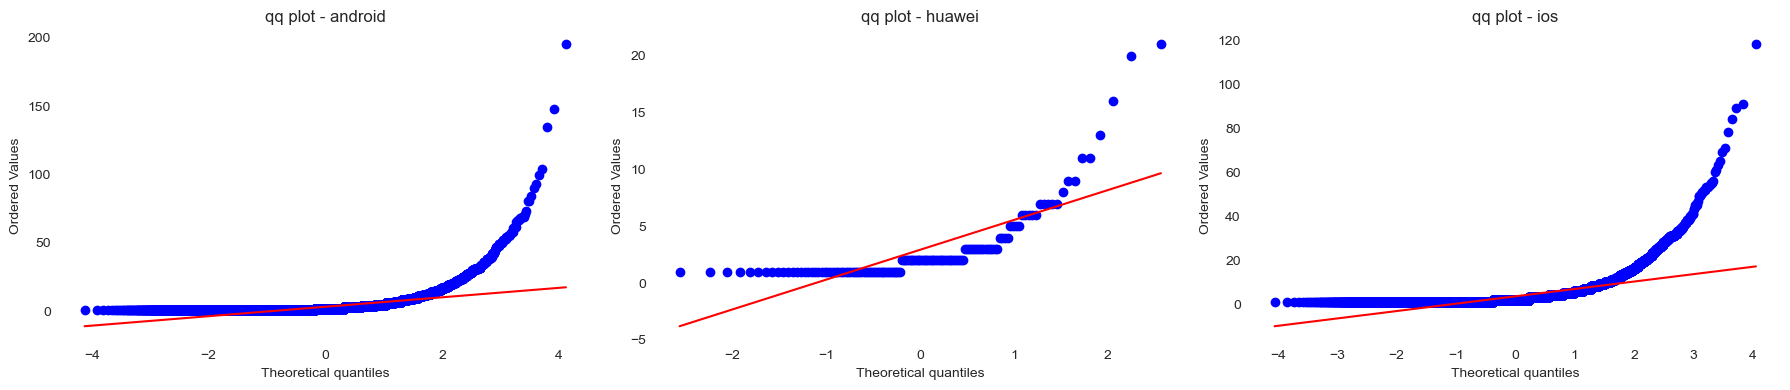

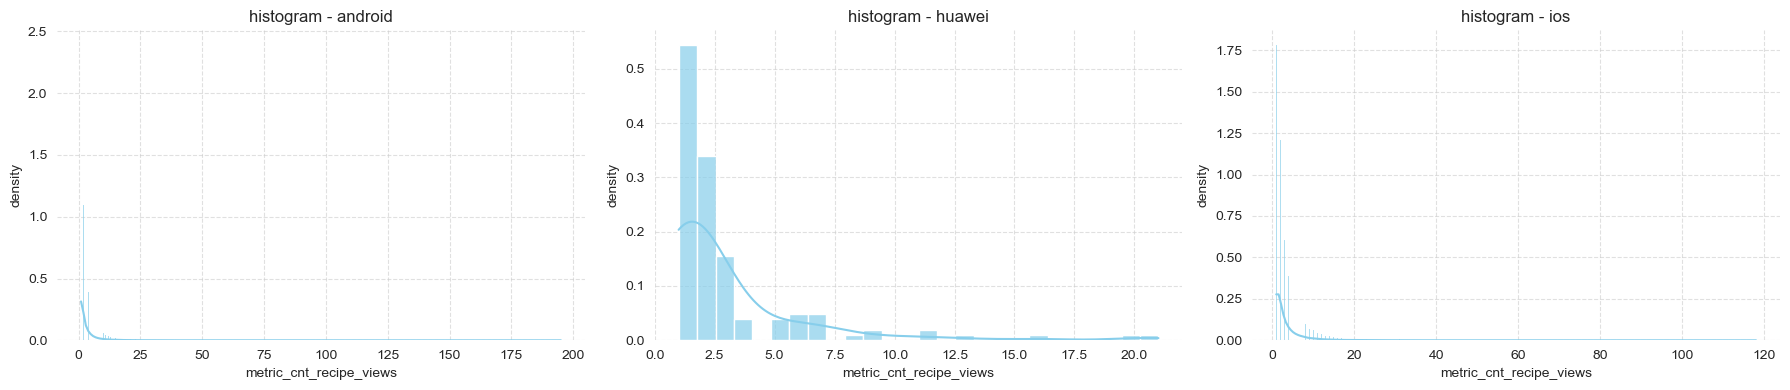

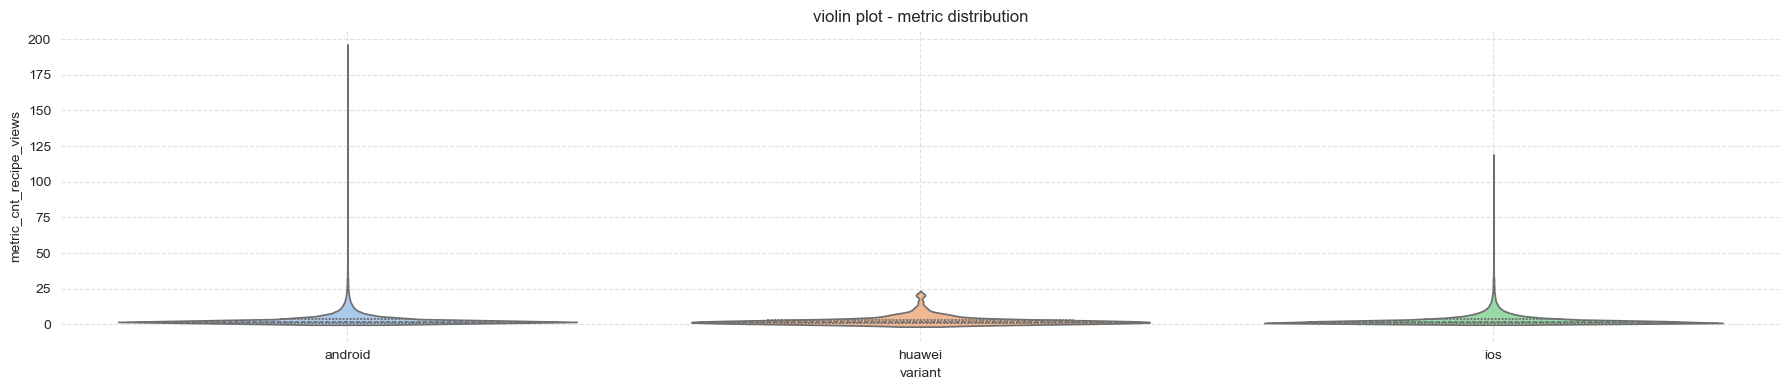

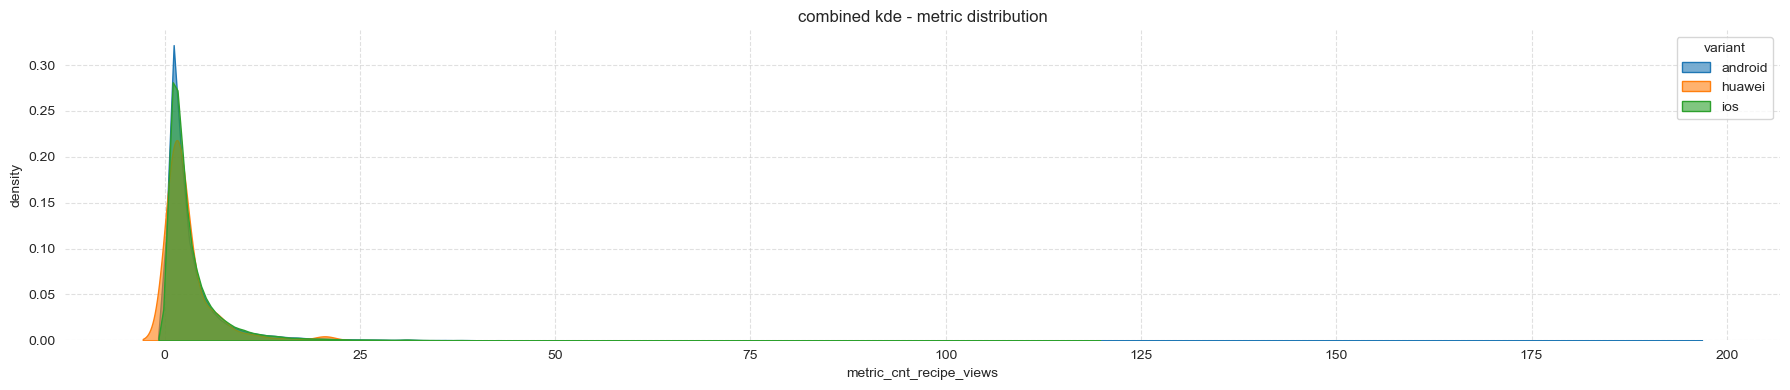

------------------------------------------- NORMAL DISTRIBUTION TEST RESULTS -------------------------------------------
variant android: normaltest statistic = 50776.7850, p-value = 0.0000
variant huawei: shapiro statistic = 0.5990, p-value = 0.0000
variant ios: normaltest statistic = 30069.9595, p-value = 0.0000

USE NORMAL DISTRIBUTION TESTS: False


In [22]:
sns.set_style("white")
print_title('NORMAL DISTRIBUTION VISUAL ANALYSIS', 120)
analysis.plot_qq(selected_df, variant_column, metric_column)
analysis.plot_histogram_kde(selected_df, variant_column, metric_column)
analysis.plot_violin(selected_df, variant_column, metric_column)
analysis.plot_combined_kde(selected_df, variant_column, metric_column)

print_title('NORMAL DISTRIBUTION TEST RESULTS', 120)
distribution_results = analysis.calculate_distribution(selected_df, variant_column, metric_column)

is_normal_distribution = analysis.set_normal_distribution_flag(distribution_results, alpha=0.05)
print(f'\nUSE NORMAL DISTRIBUTION TESTS: {is_normal_distribution}')

### SAMPLE VARIANCES

In [23]:
print_title('VARIANCE TEST RESULTS', 180)
variance_results = analysis.calculate_variance_analysis(selected_df, variant_column, metric_column)

is_equal_variance = analysis.set_equal_variance_flag(variance_results, alpha=0.05)
print(f'\nUSE EQUAL VARIANCE TESTS: {is_equal_variance}')

------------------------------------------------------------------------------ VARIANCE TEST RESULTS ------------------------------------------------------------------------------
Levene test statistic = 1.3120, p_value = 0.2693
Equal variance assumption: True

USE EQUAL VARIANCE TESTS: True


## STATISTICAL TESTING

### TEST AND TECHNICHES SELECTION

In [24]:
print_title('TEST VARIABLES', 60)
ab_test_config = ab_tests.configure_ab_test(metric_type, is_equal_variance, is_normal_distribution, num_variants, variant_ratio, sample_sizes, is_strong_outlier_effect)
print('\n')
print_title('TEST SELECTION', 60)
print({key: value for key, value in ab_test_config.items() if value})

---------------------- TEST VARIABLES ----------------------
metric_type: continuous
is_normal_distribution: False
is_equal_variance: True
num_variants: 3
sample_sizes: platform
android    37197
ios        27490
huawei       134
Name: count, dtype: int64
variant_ratio: 277.59
is_strong_outlier_effect: False


---------------------- TEST SELECTION ----------------------
{'use_kruskal_wallis_test': True, 'use_dunn_test': True, 'use_bonferroni_correction': True, 'use_bootstraping': True, 'use_bayesian_test': True}


### UNBALANCE DATA

In [25]:
selected_df = ab_tests.resample_data(selected_df, ab_test_config, variant_column)

apply_bootstraping


### TESTS

--------------------------------- TEST RESULTS ---------------------------------


,group1,group2,p_value,significant
3,android,huawei,6.273233e-10,True
4,android,ios,1.204995e-66,True
5,huawei,ios,3.217551e-125,True


-------------------------------- TEST SELECTION --------------------------------
{'use_kruskal_wallis_test': True, 'use_dunn_test': True, 'use_bonferroni_correction': True, 'use_bootstraping': True, 'use_bayesian_test': True}


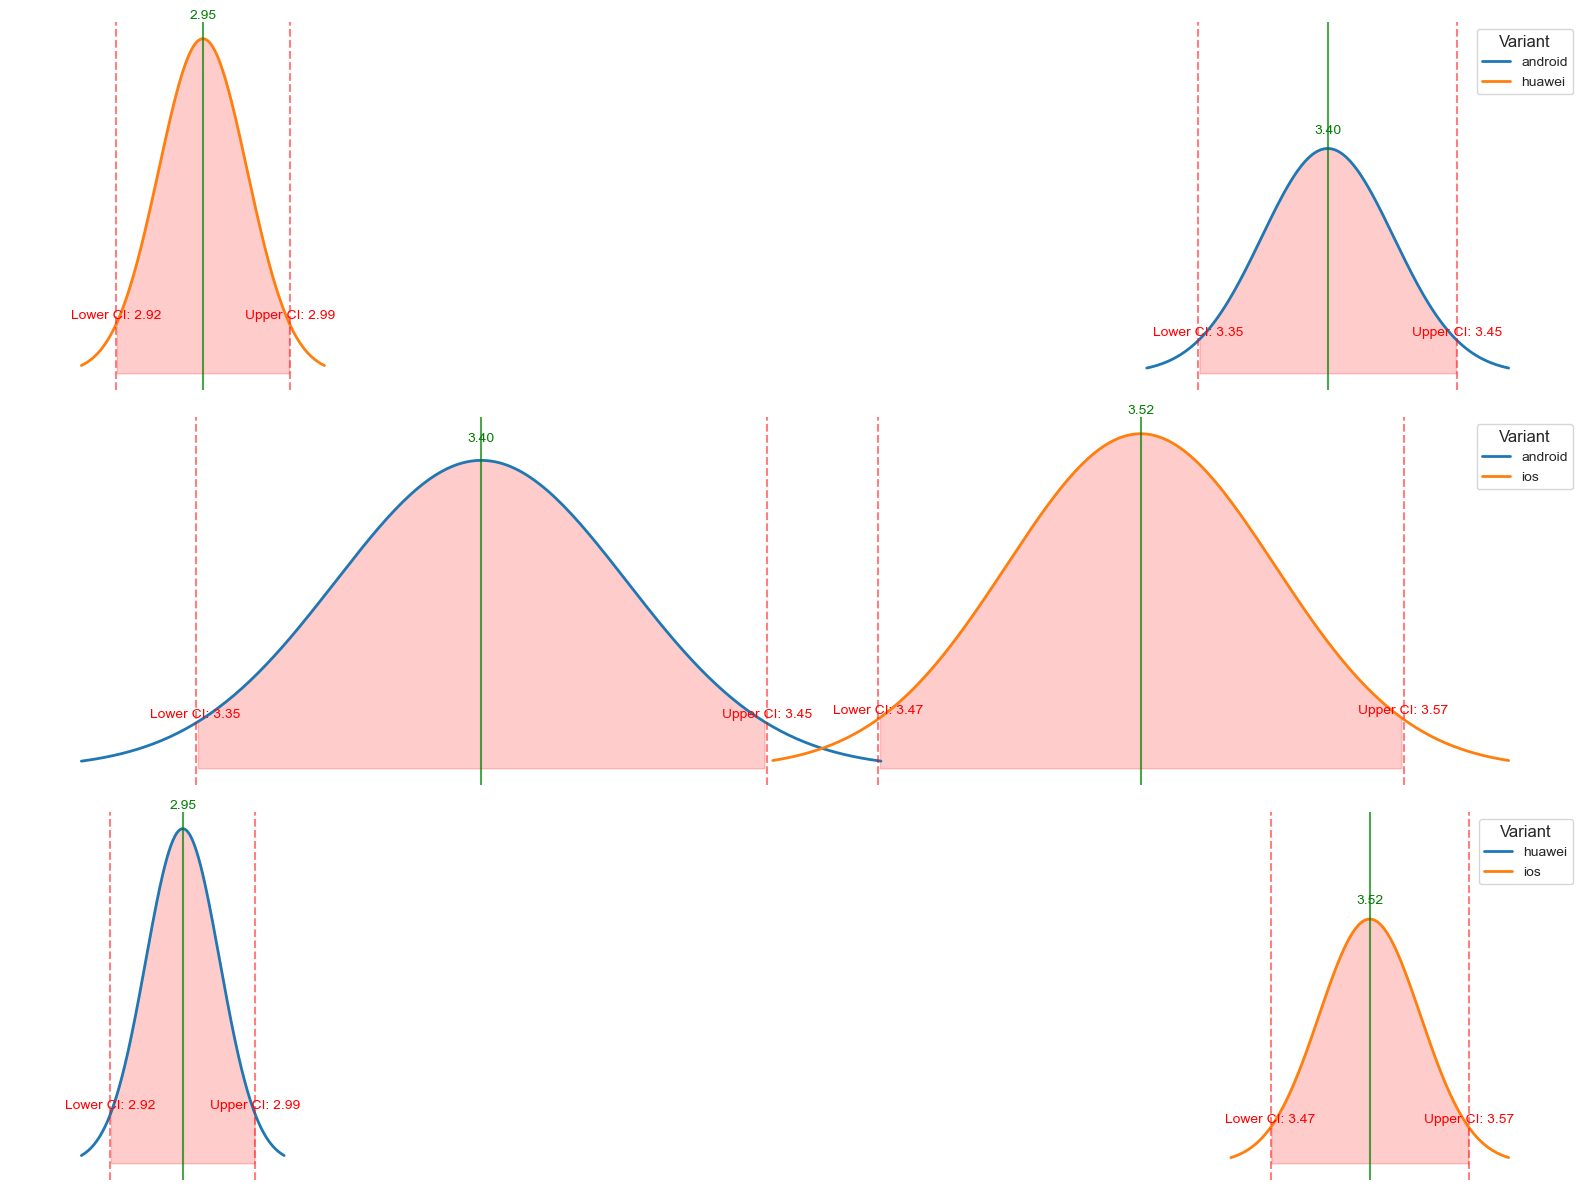

In [26]:
print_title('TEST RESULTS', 80)
standardized_results = ab_tests.run_complete_ab_test(ab_test_config, selected_df, variant_column, metric_column, num_variants, alpha = 0.05)
display(standardized_results)

print_title('TEST SELECTION', 80)
print({key: value for key, value in ab_test_config.items() if value})

framework.plot_distributions(selected_df, variant_column, metric_column, 0.05)

### ADDITIONAL TECHNIQUES

In [27]:
additional_tests_results = ab_tests.apply_additional_tests(ab_test_config, selected_df, variant_column, metric_column)
display(additional_tests_results)

{'pairwise_tests': {'android vs huawei': {'bayesian_mean_difference': -0.4467833427426946,
   'bayesian_probability': 0.468},
  'android vs ios': {'bayesian_mean_difference': 0.11855794822163057,
   'bayesian_probability': 0.501},
  'huawei vs ios': {'bayesian_mean_difference': 0.5653412909643252,
   'bayesian_probability': 0.5432}}}